In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_dev=pd.read_csv("development.tsv",sep='\t')
df_eval=pd.read_csv("evaluation.tsv",sep='\t')
df = pd.concat([df_dev, df_eval], sort=False)
print(f"dev set size {df_dev.shape[0]}, eval set size {df_eval.shape[0]}")

dev set size 70000, eval set size 30000


In [44]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beer/ABV           66893 non-null  float64
 1   beer/name          70000 non-null  object 
 2   beer/style         70000 non-null  object 
 3   review/appearance  70000 non-null  float64
 4   review/aroma       70000 non-null  float64
 5   review/overall     70000 non-null  float64
 6   review/palate      70000 non-null  float64
 7   review/taste       70000 non-null  float64
 8   review/text        69982 non-null  object 
 9   user/ageInSeconds  14645 non-null  float64
 10  user/birthdayRaw   14645 non-null  object 
 11  user/birthdayUnix  14645 non-null  float64
 12  user/gender        28181 non-null  object 
 13  user/profileName   69986 non-null  object 
dtypes: float64(8), object(6)
memory usage: 7.5+ MB


<AxesSubplot:xlabel='review/overall', ylabel='count'>

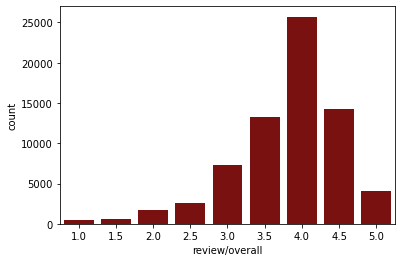

In [45]:
sns.countplot(x='review/overall',data=df_dev,color='darkred')

In [46]:
print(f"The skewness of target variable is {df_dev['review/overall'].skew()} and the kutosis is {df_dev['review/overall'].kurtosis()}")

The skewness of target variable is -1.0235674030883761 and the kutosis is 1.6288439531922938


<AxesSubplot:xlabel='user/ageInYear'>

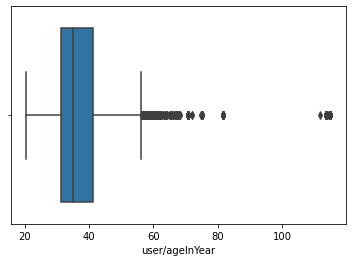

In [47]:
converter=31556952
df_dev['user/ageInYear']=df_dev['user/ageInSeconds']/converter
sns.boxplot(x='user/ageInYear',data=df_dev)

In [48]:
df_dev.drop(columns='user/ageInYear',inplace=True)

<AxesSubplot:xlabel='beer/ABV'>

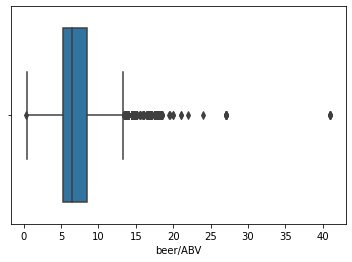

In [49]:
sns.boxplot(x='beer/ABV',data=df_dev)

Some beers have different ABV and may even have missing values.

In [50]:
df_dev[df_dev['beer/name']=='Witbier']

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
97,NaN,Witbier,Witbier,3.5,2.5,3.0,4.0,3.0,"From the notes on the menu: ""A Belgian style W...",NaN,NaN,NaN,NaN,HeroJH
6196,NaN,Witbier,Witbier,4.0,2.5,5.0,4.5,4.0,One first pour you are just blown away by the ...,NaN,NaN,NaN,NaN,Ave
33865,4.6,Witbier,Witbier,4.5,4.5,3.5,3.0,3.0,Aroma: A nice Belgian yeast nose with the oran...,NaN,NaN,NaN,NaN,HardTarget
50578,4.0,Witbier,Witbier,2.0,4.0,4.0,4.0,3.5,This beer came a washed out gold that looked m...,NaN,NaN,NaN,NaN,DarkerTheBetter


In [51]:
df_dev[df_dev['beer/name']=='Dark Marc']

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
577,NaN,Dark Marc,American Black Ale,4.0,4.0,4.0,4.0,4.0,"On draught at the Dog and Pony, Dark Marc is b...",1.137507e+09,"Nov 25, 1978",280828800.0,Male,ccrida


In [52]:
#Filling missing values for beer/ABV
for i in df.loc[df['beer/ABV'].isna(),'beer/name']:
    if df.loc[df['beer/name']==i,'beer/ABV'].isna().sum()==df[df['beer/name']==i].shape[0]:
        df.loc[df['beer/name']==i,'beer/ABV']=df.loc[df['beer/name']==i,'beer/ABV'].fillna((df['beer/ABV'].mean()))
    else:
        df.loc[(df['beer/name']==i)&(df['beer/ABV'].isna()),'beer/ABV']=\
        df.loc[(df['beer/name']==i)&(df['beer/ABV'].isna()),'beer/ABV']\
        .fillna((df.loc[df['beer/name']==i,'beer/ABV'].mean()))

<AxesSubplot:>

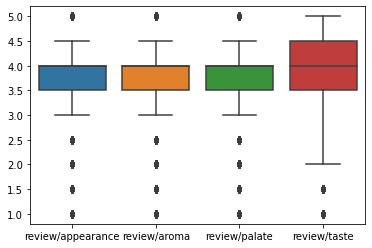

In [53]:
sns.boxplot(data=df_dev[['review/appearance','review/aroma','review/palate','review/taste']])

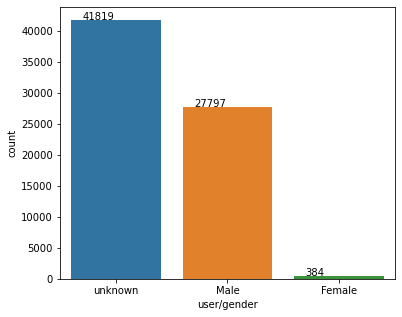

In [54]:
df_dev['user/gender'].fillna("unknown",inplace=True)
plt.figure(figsize=(6,5))
ax = sns.countplot(x="user/gender", data=df_dev, order=['unknown','Male','Female'])


for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [55]:
df_dev[['beer/name','beer/style','user/gender','user/profileName']].nunique()

beer/name           14770
beer/style            104
user/gender             3
user/profileName    10573
dtype: int64

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect =TfidfVectorizer (token_pattern=r'\w{2,}',stop_words="english",use_idf=True,max_df=0.8,min_df=0.01)
wpm=vect.fit_transform(df["review/text"].fillna(""))
freq = sorted(zip(vect.get_feature_names(), wpm.sum(axis=0).tolist()[0]), key=lambda x: x[1], reverse=True)
words = [ word for word, _ in freq ]
mask = [ w in words for w in vect.get_feature_names() ]
words_ = [ w for w in vect.get_feature_names() if w in words ]
words_df = pd.DataFrame(data=wpm[:, np.array(mask)].toarray(), columns=[f"word_{word}" for word in words_],index=df.index)
df_new=df.drop(columns=['review/text','user/birthdayUnix','user/birthdayRaw','beer/name','user/gender'])
df_new = pd.concat([df_new, words_df], axis=1)
converter=31556952
df_new['user/ageInSeconds'].fillna((df_new['user/ageInSeconds'].mean()),inplace=True)
df_new['user/ageInSeconds']=df_new['user/ageInSeconds']/converter
df_new['user/ageInSeconds'] = (df_new['user/ageInSeconds']+1).transform(np.log)

In [42]:
len(freq)

841

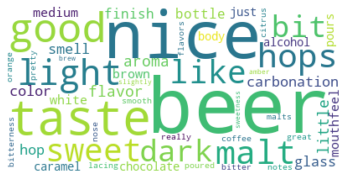

In [57]:
from wordcloud import WordCloud
feature_names = vect.get_feature_names()
dense = wpm.todense()
lst1 = dense.tolist()
wc = pd.DataFrame(lst1, columns=feature_names)
wc.T.sum(axis=1)
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(wc.T.sum(axis=1))
plt.figure()
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
df_new.loc[df_new['user/profileName'].isin(list(df_new['user/profileName'].value_counts()[671:].index)),'user/profileName']='other'
df_new = pd.get_dummies(df_new, columns=['user/profileName'])
df_new.loc[df_new['beer/style'].isin(list(df_new['beer/style'].value_counts()[27:].index)),'beer/style']='other'
df_new = pd.get_dummies(df_new, columns=['beer/style'])

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,LinearRegression

train_valid_mask = ~df_new["review/overall"].isna()
feature_names = df_new[train_valid_mask].drop(columns=["review/overall"]).columns
X = df_new.drop(columns=["review/overall"]).values
y = df_new["review/overall"].values
X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]
X_eval = X[~train_valid_mask]
y_eval = y[~train_valid_mask]
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
X_train, X_test, y_train, y_test = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42,test_size=1-train_ratio)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, shuffle=True, random_state=42,test_size=test_ratio/(test_ratio + validation_ratio))

Tuning hyperparameters

In [19]:
svr1=SVR(C=0.1)
svr1.fit(X_train, y_train)
r2_score(y_valid, svr1.predict(X_valid))

0.6879010003639854

In [20]:
svr2=SVR(C=1)
svr2.fit(X_train, y_train)
r2_score(y_valid, svr2.predict(X_valid))

0.7055615048904049

In [18]:
svr3=SVR(C=10)
svr3.fit(X_train, y_train)
r2_score(y_valid, svr3.predict(X_valid))

0.7098730015036638

In [83]:
lr1=LinearRegression(fit_intercept=True)
lr1.fit(X_train, y_train)
r2_score(y_valid, lr1.predict(X_valid))

0.6990734440164093

In [84]:
lr2=LinearRegression(fit_intercept=False)
lr2.fit(X_train, y_train)
r2_score(y_valid, lr2.predict(X_valid))

0.6990637949806444

In [20]:
rfr1=RandomForestRegressor(n_estimators=250,max_depth=None,n_jobs=-1)
rfr1.fit(X_train, y_train)
r2_score(y_valid, rfr1.predict(X_valid))
#0.6842776354754101

0.6856542441810598

In [21]:
rfr2=RandomForestRegressor(n_estimators=500,max_depth=None,n_jobs=-1)
rfr2.fit(X_train, y_train)
r2_score(y_valid, rfr2.predict(X_valid))

0.6867483210451666

In [28]:
rfr3=RandomForestRegressor(n_estimators=100,max_depth=None,n_jobs=-1)
rfr3.fit(X_train, y_train)
r2_score(y_valid, rfr3.predict(X_valid))

0.684081528458959

In [29]:
rfr4=RandomForestRegressor(n_estimators=100,max_depth=50,n_jobs=-1)
rfr4.fit(X_train, y_train)
r2_score(y_valid, rfr4.predict(X_valid))

0.6833680980093217

In [30]:
rfr5=RandomForestRegressor(n_estimators=250,max_depth=50,n_jobs=-1)
rfr5.fit(X_train, y_train)
r2_score(y_valid, rfr5.predict(X_valid))

0.686670962392851

In [31]:
rfr6=RandomForestRegressor(n_estimators=500,max_depth=50,n_jobs=-1)
rfr6.fit(X_train, y_train)
r2_score(y_valid, rfr6.predict(X_valid))

0.6866039865930839

In [24]:
r1=Ridge(alpha=1)
r1.fit(X_train, y_train)
r2_score(y_valid, r1.predict(X_valid))

0.6999686089459136

In [25]:
r2=Ridge(alpha=5)
r2.fit(X_train, y_train)
r2_score(y_valid, r2.predict(X_valid))

0.7011181707571669

In [26]:
r3=Ridge(alpha=15)
r3.fit(X_train, y_train)
r2_score(y_valid, r3.predict(X_valid))

0.7018964938276763

In [21]:
l1=Lasso(alpha=0.001)
l1.fit(X_train, y_train)
r2_score(y_valid, l1.predict(X_valid))

0.6807140695740925

In [22]:
l2=Lasso(alpha=0.0001)
l2.fit(X_train, y_train)
r2_score(y_valid, l2.predict(X_valid))

0.6986780239038239

In [23]:
l3=Lasso(alpha=0.00001)
l3.fit(X_train, y_train)
r2_score(y_valid, l3.predict(X_valid))

0.7013428294131359

Model Selection of best configurations of the models on the test portion

In [60]:
X_train_new=np.concatenate((X_train,X_valid))
y_train_new=np.concatenate((y_train,y_valid))

In [105]:
best_svr=SVR(C=10)
best_svr.fit(X_train_new,y_train_new)
r2_score(y_test,best_svr.predict(X_test))

0.716338340823122

In [101]:
best_lr=LinearRegression(fit_intercept=True)
best_lr.fit(X_train_new,y_train_new)
r2_score(y_test,best_lr.predict(X_test))

0.7052023016660179

In [61]:
best_rfr=RandomForestRegressor(n_estimators=500,max_depth=None,n_jobs=-1)
best_rfr.fit(X_train_new,y_train_new)
r2_score(y_test,best_rfr.predict(X_test))

0.6978548678379191

In [28]:
best_r=Ridge(alpha=15)
best_r.fit(X_train_new,y_train_new)
r2_score(y_test,best_r.predict(X_test))

0.708404941799504

In [29]:
best_l=Lasso(alpha=0.00001)
best_l.fit(X_train_new,y_train_new)
r2_score(y_test,best_l.predict(X_test))

0.7071211823793

Final Model (SVR) on evaluation set

In [ ]:
final_model=SVR(C=10)
final_model.fit(X_train_valid, y_train_valid)
y_pred1=final_model.predict(X_eval)

In [64]:
pd.DataFrame(y_pred3, index=df_new[~train_valid_mask].index).to_csv("outputforest.csv",index_label="Id", header=["Predicted"])

In [97]:
l=sorted(zip(feature_names, best_rfr.feature_importances_), key=lambda x: x[1],reverse=True)[:5]

In [98]:
top_features=list(map(lambda x:x[0],l))
importance=list(map(lambda x:x[1],l))

<BarContainer object of 5 artists>

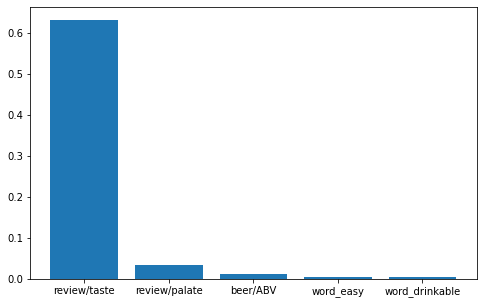

In [100]:
fig = plt.figure(figsize = (8, 5))
 
plt.bar(top_features, importance)